### Modelo de simulación Montecarlo utilizando Numpy & Scipy  aplicando Geometric Brownian Motion

## Fase 1 Obtención y Procesado de Datos

#### 1. Importación de Librerías

En primer lugar, importamos las librerías de Python con las que vamos a trabajar para este ejercicio. Para la lectura del marco de datos utilizaremos **Pandas**, para la gestión de las matrices de simulación y algunos **Numpy** y para métricas estadísticas, en este caso utilicaremos **Scipy**. Por último las visualizaciones vendrán a cargo de matplotlib.pyplot.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
sns.set_theme()
%matplotlib inline

#### 2. Lectura de datos

La obtención de datos de cotización, en este caso viene provista **a través de una hoja de cálculo** con la extensión .csv. Por tanto la leeremos utilizando la función read_csv de pandas, en la cual introducimos el nombre del archivo y la columna que actuará de índice. Asignaremos el nombre de *data* a esa variable.

Si queremos obtener **datos en línea** de los activos de cotización podemos utilizar otras liberías como Investpy, Pandas_Datareader, Yfinance, Quandl, etc. Esto permitiría hacer el programa dinámico dependiendo del Ticker que quisiésemos utilizar.

Ej: data = pdr.get_data_yahoo('MSFT', start='2019-01-01', end='2022-03-02')['Adj Close'] < Para acceder al precio de cierre


Por último visualizamos los datos con la extensión data.tail(), data.head() o data.info() dependiendo del interés que tengamos en visualizar.

In [2]:
data = pd.read_csv('MSFT_2000.csv', index_col='Date')
data.tail()


,MSFT
Date,
2017-10-12,77.120003
2017-10-13,77.489998
2017-10-16,77.650002
2017-10-17,77.589996
2017-10-18,77.610001


#### 3. Procesado de datos

Una vez accedemos a los datos, podemos procesarlos fácilmente para obtener métricas que necesitamos para la ejecución de nuestra tarea. En este caso obtenemos:

1. Los **retornos logarítmicos** (log_returns) ya que éstos poseen propiedades que buscamos para realizar nuestros cálculos. Para ello utilizaremos np.log(1 + data.pct_change()) o el equivalente np.log(data/data.shift(1))
2. Cálculos sobre los mismos como la **Media, varianza y desviación estándar**. Mediante la aplicación de la función .mean(), .var() y .std() sobre los datos que nos interesan. Ej: media = log_returns.mean()


In [3]:
log_returns = np.log(1 + data.pct_change())
log_returns.head()

,MSFT
Date,
1999-12-31,NaN
2000-01-03,-0.001607
2000-01-04,-0.034364
2000-01-05,0.010489
2000-01-06,-0.034072


#### 4. Visualización de datos

Si en nuestra tarea requerimos de visualizaciones, existen diferentes librerías que permiten funcionalidades y estilos diversos. En este caso utilizamos la **función de .plot()** sobre los datos que queremos visualizar de forma simplificada y elegimos el tamaño de la imagen. 

Otras librerías podrían ser seaborn, plotly, etc.

<AxesSubplot:xlabel='Date'>

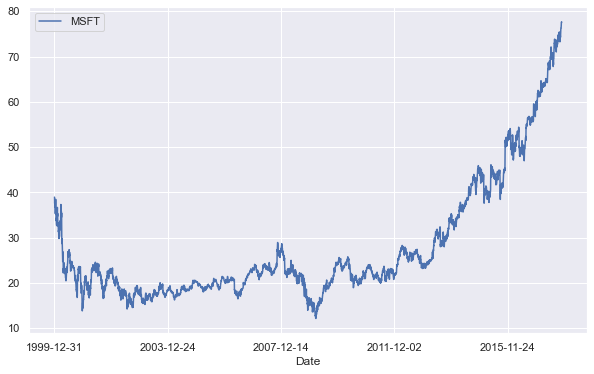

In [4]:
data.plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

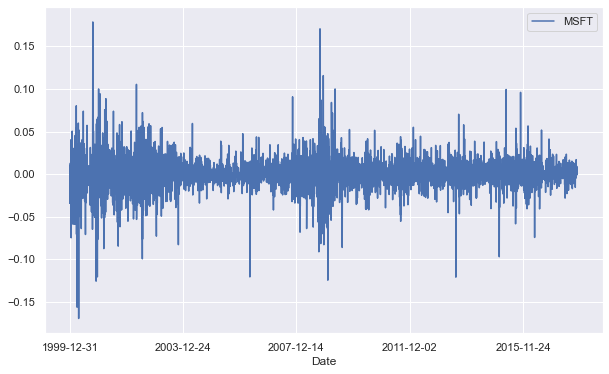

In [5]:
log_returns.plot(figsize = (10,6))

#### 5. Formulación

En cuanto a la formulación podemos trabajar en base a dos situaciones. Por un lado, nos encontramos ante los **datos históricos** y por otro ante los **datos futuros o a simular**. Esto nos lleva a entender nuestra formulación de la siguiente manera.

Datos históricos:
1. $PrecioHoy = PrecioAyer * e^r$
2. $r = ln(PrecioHoy/precioAyer)$ 

Datos Simulados:

Sin embargo, la fórmula $PrecioHoy = PrecioAyer * e^r$ para los datos a simular nos plantea la incógnita de $r$. Sabemos que el precio de hoy estará en función de el precio de cierre de ayer y el retorno diario. Aquí es donde introducimos el ***Movimiento Geométrico Browniano***, que nos permitirá "modelar" la variable del retorno diario $r$. 

El movimiento geométrico browniano está compuesto de dos elementos: 
1. El coeficiente de deriva: $ drift = \mu - 0.5· \sigma^2$


2. Variable Aleatoria. $\sigma  x  Z(Rand(0;1))$.

Por tanto, **la ecuación sobre la que trabajamos para estimar el precio del activo** durante la simulación quedaría expresada de la siguiente manera:

$PrecioHoy = PrecioAyer * e^{(\mu-0.5·\sigma^2)+\sigma· Z[Rand(0;1)]}$

Donde:

$\mu = u =$ Media de log_return


$\sigma^2 =var =$ Varianza de log_return

 
$\sigma = stdev =$ Desviación Estándar de log_return


$Z(Rand(0;1))$ seremos capaces de estimarlo mediante las funcionalidades de Numpy y lo veremos con mayor profundidad en la siguiente sección.

#### Obtención de métricas

In [6]:
u = log_returns.mean()
u

MSFT    0.000154
dtype: float64

In [7]:
var = log_returns.var()
var

MSFT    0.000376
dtype: float64

In [8]:
drift = u - (0.5 * var)
drift

MSFT   -0.000034
dtype: float64

In [9]:
stdev = log_returns.std()
stdev

MSFT    0.019397
dtype: float64

#### Conversión de datos al formato adecuado para su utilización posterior.

Una vez hemos obtenido los datos necesarios para aplicar nuestra formulación y calcular los valores, necesitamos ***preparar el marco de trabajo donde la simulación tendrá lugar***. Como comentamos anteriormente, utilizaremos numpy y sus array para almacenar los precios proyectados. 

Al haber trabajado con pandas previamente para el manejo de datos, es importante **evaluar qué estructura computacional** tiene el valor almacenado. Para ello utilizamos la función type() que nos permite conocer cuál es esa estructura. Como podemos ver,la estructura es "pandas.core.series.Series". 

Sin embargo, para evitar problemas de compatibilidad, potenciales errores y trabajar en el mismo formato de datos, buscaremos **convertir esas pandas.core.series en numpy.arrays**. Simplemente mediante la función np.array() y el valor que deseemos convertir en el interior (). 

In [10]:
type(drift)

pandas.core.series.Series

In [11]:
type(stdev)

pandas.core.series.Series

In [12]:
np.array(drift)

array([-3.42521946e-05])

In [13]:
stdev.values

array([0.01939682])

## Fase 2 Aparato de Cálculo para la Simulación


Una vez tenemos los valores anteriores almacenados, el único elemento que nos queda para poder aplicar la fórmula sobre la que estimar nuestros precios futuros es $Z$. 


Este elemento $Z$, generalmente viene determinado como la distancia entre el evento y la media, expresado en número de desviaciones estándar.

Utilizando un ejemplo norm.ppf(0.95) podemos ver que un evento que tenga una probabilidad de ocurrir de un 95%, tendrá como distancia a la media 1.65 Desviaciones Estándar.


In [14]:
norm.ppf(0.95)

1.6448536269514722

#### 6. Generación aleatoria de números

La función utilizada en el ejemplo para la generación aleatoria de números es **np.random.rand()** genera un array aleatorio que sigue una **distribución uniforme**. Es posible también encontrar en otros ejemplos u otras simulaciones otros tipos de distribuciones en la generación aleatoria de números como np.random.normal(), np.random.standard_normal(), etc. La utilización dependerá del propósito o activo en la simulación.

Es importante ***tener en cuenta los datos sobre los que se extraen las variables para el escenario de simulación. Ya que las variables ($\sigma, \mu, \sigma^2$) y la distribución aplicada en la generación aleatoria de números influirá en el desarrollo de los paths de simulación de precios.***

En los siguientes ejemplos podremos ver cómo se genera una distribución uniforme en un array (10,2) en una variable que asignaremos con la letra $x$. 

$x$ = np.random.rand(10,2)

Después veremos cómo obtener $Z$ aplicando la función norm.ppf() a los valores aleatorios que volvemos a generar, explicada en el ejemplo anteriormente.

$Z$ = norm.ppf(np.random.rand(10,2))

In [15]:
x = np.random.rand(10,2)
x

array([[0.00404839, 0.71241024],
       [0.48515019, 0.31057318],
       [0.76732016, 0.77078351],
       [0.73180661, 0.42753882],
       [0.60608401, 0.56948765],
       [0.62710127, 0.52557692],
       [0.44924529, 0.78427031],
       [0.22005787, 0.56676802],
       [0.8968734 , 0.77143972],
       [0.48052606, 0.08116206]])

In [16]:
norm.ppf(x)

array([[-2.6480069 ,  0.56043976],
       [-0.03723156, -0.49422631],
       [ 0.7300499 ,  0.74142964],
       [ 0.61828607, -0.18264363],
       [ 0.26912698,  0.17506992],
       [ 0.32418569,  0.06415582],
       [-0.12756835,  0.78669679],
       [-0.77199779,  0.16815167],
       [ 1.26393545,  0.7435966 ],
       [-0.04883333, -1.39729753]])

In [17]:
Z = norm.ppf(np.random.rand(10,2))
Z

array([[-0.64960941,  0.5651657 ],
       [-0.61876319, -0.70491123],
       [-1.53338953, -0.64452734],
       [-0.96707126, -1.71154155],
       [-0.00489733, -2.07158794],
       [-0.64955562,  0.51935314],
       [ 1.13051079, -0.5804784 ],
       [-1.06839972,  1.24554994],
       [ 0.57542456,  0.51200547],
       [ 0.5889121 , -0.78671878]])

In [18]:
t_intervals = 1000 # Número de time steps para la simulación
iterations = 10 # Número de paths a seguir en la simulación

#### 7. Creación de la simulación de retornos

Una vez hemos definido el número de intervalos o pasos para la simulación 1000, el número de caminos o paths 10 y hemos conseguido una metodología para obtener $Z$, estamos listos para simular nuestros retornos diarios aplicando la fórmula:

1. $r= e^{(\mu-0.5·\sigma^2)+\sigma· Z[Rand(0;1)]}$

Donde $Z =$ norm.ppf(np.random.rand(t_intervals, iterations)

Ya que la matriz que usaremos será (t_intervals x iterations)

In [19]:
daily_returns = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations)))
daily_returns

array([[1.00543589, 0.9532614 , 1.01439009, ..., 1.00122327, 1.00531038,
        1.0099002 ],
       [1.0254115 , 0.98882246, 1.04622228, ..., 0.96511178, 0.95072006,
        1.02404586],
       [0.98143825, 0.99219256, 1.00820669, ..., 1.01806376, 0.96670747,
        1.01083549],
       ...,
       [1.0030799 , 0.99055146, 0.95568359, ..., 1.00054965, 0.97020494,
        1.00770107],
       [0.99707016, 1.00756631, 1.0468086 , ..., 0.96624752, 1.01980031,
        1.04654107],
       [0.99494504, 1.03303762, 1.01322425, ..., 1.00738837, 1.03737722,
        1.00142612]])

## Fase 3 Preparación estructural de la simulación

#### 8. Iniciamos la Matriz

Una vez tenemos nuestro array con los daily returns, necesitamos un lugar para almacenar el resultado de aplicar esos retornos al precio de inicio. 

Para ello, necesitamos diseñar el espacio donde **vamos a almacenar los datos**. Esto es una matriz vacía que tenga la dimensión de nuestra simulación. Por un lado el número de simulaciones (paths) y por otro el número de intervalos temporales a simular (steps). 

Los pasos por tanto serían:
1. Accedemos al **valor inicial** sobre el que queremos empezar a aplicar los retornos obtenidos mediante la función iloc. Nuestro último precio de cierre S0 = data.iloc[-1]

2. **Creamos una matriz vacía** con las dimensiones adecaudas mediante la función de Numpy zeros_like.

3. **Añadimos el precio de inicio** de la simulación S0 a la primera fila de nuestra matriz [0] mediante price_list[0] = S0

In [20]:
S0 = data.iloc[-1] # accedemos al precio de cierre de nuestro DataFrame
S0

MSFT    77.610001
Name: 2017-10-18, dtype: float64

In [21]:
price_list = np.zeros_like(daily_returns)
price_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
price_list[0] = S0 # Asignamos el precio de cierre al primer valor de cada array para multiplicar los returns.
price_list

array([[77.610001, 77.610001, 77.610001, ..., 77.610001, 77.610001,
        77.610001],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

#### 9. Loop para rellenar los precios

Finalmente, podemos proceder al loop de la simulación. Hacemos la iteración sobre los intervalos temporales desde (1 hasta t_intervals) ya que el primer precio [0], S0 lo tenemos cargado en el primer espacio. Diciendo que:

1. **nuestro precio hoy** (price_list[t]) **= precio de ayer** (price_list[t-1]) **· retorno de hoy** (daily_returns[t])

Que es lo mismo que decir:

2. $PrecioHoy = PrecioAyer * e^{(\mu-0.5·\sigma^2)+\sigma· Z[Rand(0;1)]}$



In [23]:
for t in range(1,t_intervals):
    price_list[t] = price_list[t-1] * daily_returns[t]
price_list    

array([[ 77.610001  ,  77.610001  ,  77.610001  , ...,  77.610001  ,
         77.610001  ,  77.610001  ],
       [ 79.58218782,  76.74251202,  81.19731202, ...,  74.90232593,
         73.78538493,  79.47619999],
       [ 78.10500306,  76.14334975,  81.86367311, ...,  76.25534335,
         71.32888262,  80.33736391],
       ...,
       [ 98.2037842 , 127.16869575,  69.92735106, ...,  34.24470541,
         84.170336  , 266.91676457],
       [ 97.91606255, 128.13089336,  73.20055259, ...,  33.0888618 ,
         85.83693473, 279.3393566 ],
       [ 97.42110099, 132.36403329,  74.16857475, ...,  33.33333469,
         89.04528058, 279.73772884]])

#### 10. Visualización de la simulación

Por último, si deseamos ver nuestra simulación de **forma gráfica**, creamos una figura en la que añadimos los valores que deseemos observar, en este caso (price_list) como hicimos anteriormente con el precio o los retornos. Las opciones de visualización, extracción de datos del array final, etc dependerá del propósito sobre el cual hemos realizado nuestra simulación.

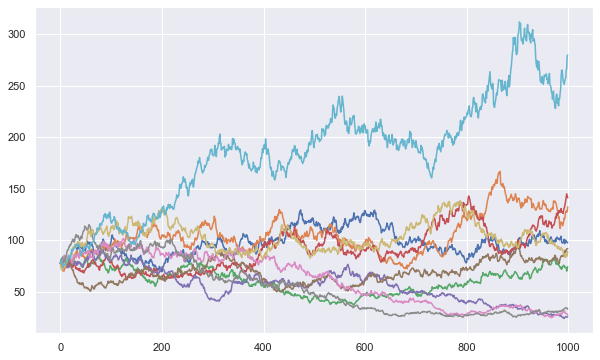

In [24]:
plt.figure(figsize=(10,6))
plt.plot(price_list)

# COMENTARIO FINAL

Puesto que nuestra simulación está basada en 1000 sesiones ya que en el modelo trabajamos para simular el precio diario del activo, comenzando desde el día 2017-10-18 (S0), sería interesante ver cuál ha sido el desarrollo del activo durante 1000 sesiones. Ya que la fecha real es posterior al modelo de simulación.

De este modo podremos obtener una rápida visualización de cómo de preciso es nuestro modelo de simulación para el activo seleccionado en comparación con su valor real y obtener las métricas que nos ayuden a evaluar la precisión de los valores estimados utilizados en la Geometric Brownian Motion.

Para ello, utilizaremos uno de los múltiples módulos de Python que permiten acceso a datos de cotización para ***1000 sesiones del activo desde la fecha de inicio.***

In [25]:
import pandas_datareader as pdr

cierre_real = pdr.get_data_yahoo('MSFT', start = '2017-10-18' , end= '2021-10-07')['Adj Close']

# Ya que buscamos simplemente el precio de cierre
print(f'Datos de precio diario de MSFT para {len(cierre_real)} sesiones')

cierre_real.head()


Datos de precio diario de MSFT para 1000 sesiones


Date
2017-10-18    73.251236
2017-10-19    73.534355
2017-10-20    74.383812
2017-10-23    74.402710
2017-10-24    74.431007
Name: Adj Close, dtype: float64

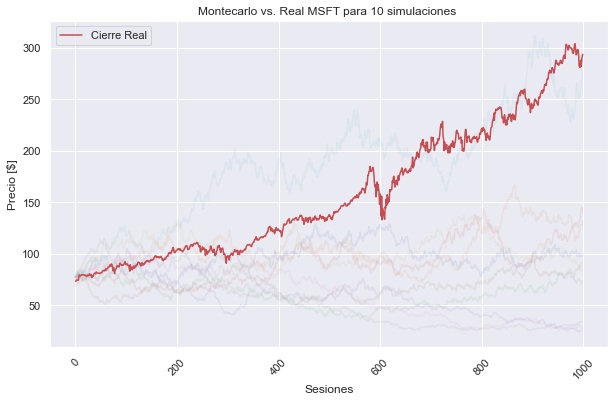

In [26]:
plt.figure(figsize=(10,6))
plt.plot(price_list, alpha=0.1)
plt.plot(range(0,len(cierre_real)), cierre_real, label='Cierre Real', color='r')
plt.title('Montecarlo vs. Real MSFT para 10 simulaciones ')
plt.ylabel('Precio [$]')
plt.xlabel('Sesiones')
plt.xticks(rotation=45)
plt.legend()

#### 11. Primera interpretación de resultados

Si bien es cierto que ***10 simulaciones no son suficientes para obtener estimaciones del precio del activo***, la primera aproximación que deberíamos hacer sería la de incrementar el número de simulaciones para ver si obtenemos unos resultados más precisos. En el segundo ejemplo, utilizaremos 10000. No incrementaremos a más en este caso por no requerir mayor demanda computacional, sin embargo sería interesante pobar con al menos $10^5$ o $10^6$.

También sería intersante ***definir una función para evitar repetir código*** al cambiar número de simulaciones, activo, etc. 

**def montecarlo_simulación (iterations, time_steps, asset, etc.):**


In [27]:
iterations_2 = 10000 # Número de paths a seguir en la simulación

daily_returns_2 = np.exp(drift.values + stdev.values * norm.ppf(np.random.rand(t_intervals, iterations_2)))
price_list_2 = np.zeros_like(daily_returns_2)
S0 = data.iloc[-1] 
price_list_2[0] = S0


for t in range(1,t_intervals):
    price_list_2[t] = price_list_2[t-1] * daily_returns_2[t]
price_list_2    

array([[ 77.610001  ,  77.610001  ,  77.610001  , ...,  77.610001  ,
         77.610001  ,  77.610001  ],
       [ 76.72458845,  77.23228049,  78.64101176, ...,  77.45967712,
         79.05658455,  75.96521449],
       [ 76.3895795 ,  79.37769208,  79.00745256, ...,  77.99780247,
         80.87875351,  77.1609961 ],
       ...,
       [ 55.28418076, 137.86021455,  82.35915073, ...,  76.70287826,
        230.3056794 ,  95.52111375],
       [ 55.1437474 , 137.12036936,  84.50260075, ...,  76.08504602,
        227.01146636,  96.33653648],
       [ 53.99676908, 133.76139329,  84.66582268, ...,  76.00453581,
        224.78780031,  97.95718095]])

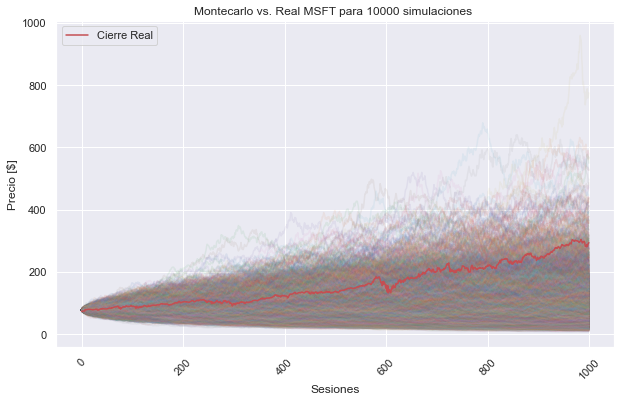

In [28]:
plt.figure(figsize=(10,6))
plt.plot(price_list_2, alpha=0.1)
plt.plot(range(0,len(cierre_real)), cierre_real, label='Cierre Real', color='r')
plt.title('Montecarlo vs. Real MSFT para 10000 simulaciones ')
plt.ylabel('Precio [$]')
plt.xlabel('Sesiones')
plt.xticks(rotation=45)
plt.legend()

#### 12. Interpretación de la segunda simulación

Una vez implementamos la segunda simulación y la aplicamos buscaremos comprobar algunas métricas esenciales para ***ver si nuestro modelo se aproxima más a la realidad sin profundizar más en el desarrollo***. Para ello podemos obtener las medias de precio de la simulación, o la media de precios de los valores terminales. 

In [29]:
print(f'Primera simulación con 10 paths Media de precio = {price_list.mean():.2f}')
print(f'Segunda simulación con 10000 Media de precio = {price_list_2.mean():.2f}')
print(f'Primera simulación con 10 paths Media de precio valor terminal = {price_list[t_intervals-1].mean():.2f}')
print(f'Primera simulación con 10000 paths Media de precio valor terminal= {price_list_2[t_intervals-1].mean():.2f}')

Primera simulación con 10 paths Media de precio = 88.43
Segunda simulación con 10000 Media de precio = 83.51
Primera simulación con 10 paths Media de precio valor terminal = 99.15
Primera simulación con 10000 paths Media de precio valor terminal= 89.76


#### 13. Conclusiones posteriores a la segunda simulación

Una vez ejecutada la segunda simulación, podemos obtener varias conclusiones:
1. ***El valor medio terminal difiere por mucha diferencia del valor real del activo para 1000 time steps.***
2. ***El modelo parece funcionar bien hasta aproximadamente la mitad de la simulación.*** Deberíamos establecer si hay factores externos impactando en el activo, de mercado en general o es el modelo en sí.

En este punto podríamos obtener métricas para indagar en ***la precisión que tiene el modelo comparado con los valores reales*** en términos porcentuales y comenzar a ***establecer potencial modelo tipo "trailing"*** que recalcule los parámetros de simulación para la ecuación de la Geometric Brownian Motion de forma dinámica para un timeframe de alrededor de 500 pasos. Con esto básicamente ***buscariamos actualizar el modelo de forma dinámica*** y sería una potencial línea de trabajo.

Por último, podríamos trabajar sobre los modelos estimados de deriva $drift$ y distribución de los retornos $Z$ dependiendo del activo utilizado comprobando si una distribución uniforme, normal, etc. funciona mejor para el activo seleccionado. 

C:\Users\javie\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

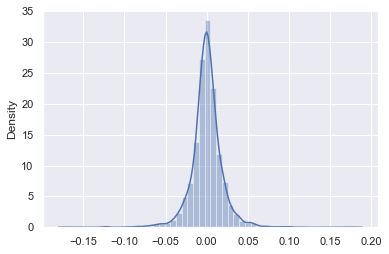

In [30]:
import seaborn as sns

sns.distplot(log_returns) # Distribución de los retornos logarítmicos

C:\Users\javie\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

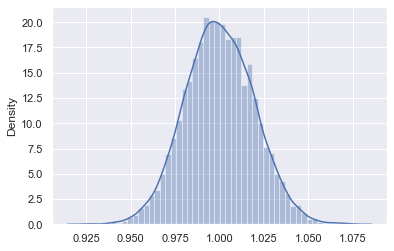

In [31]:
sns.distplot(daily_returns) # Distribución de los daily returns

C:\Users\javie\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

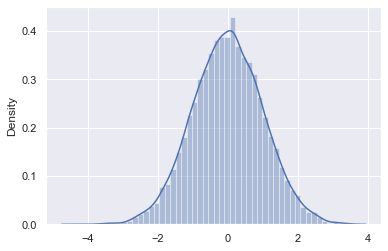

In [32]:
sns.distplot(norm.ppf(np.random.rand(t_intervals, iterations))) # Distribución de Z